# Table of Contents
 <p><div class="lev1"><a href="#Some-maps"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some maps</a></div><div class="lev2"><a href="#Example-maps-of-precipitation,-omega_500,-qvstar_925"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example maps of precipitation, omega_500, qvstar_925</a></div><div class="lev2"><a href="#Example-maps-of-coarsened-precipitation"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example maps of coarsened precipitation</a></div><div class="lev1"><a href="#Figures-at-a-specific-scale"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figures at a specific scale</a></div><div class="lev1"><a href="#Multiscale-figures"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multiscale figures</a></div>

In [2]:
%load_ext autoreload
%matplotlib inline

In [11]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from importingData import *
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [15]:
time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx'
N_times = len(time_strides)
N_res = len(resolutions)

print("choose run options")
scaling = 'omega500tsps'
# compset = 'FSPCAMm_AMIP'
compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
dates_label = '185005010100-185105010000'
ranks_label = 'Q8-Q41'
time_ref = '1d'
res_ref = '1dx'
daskarray = False

# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)

print()
print("get inputpaths")

# Local input directory
historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

choose run options

get inputpaths


# Some maps

## Example maps of precipitation, omega_500, qvstar_925

In [9]:
## Get longitude, latitude and landmask
print("load lontigude, latitude and landmask")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)


landmask = fh.variables['landmask']


load lontigude, latitude and landmask


In [24]:
print("load physical variables data")

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'
dates_maps = '185005010100','185005020000'
handle = 'h0'

omega,pr,ta,relhum,ps = \
    getValues([omega_id,pr_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,time_ref,res_ref,
              daskarray=daskarray,dates=dates_maps,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)

load physical variables data
Importing OMEGA, PRECT, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
compute pressure levels


In [26]:
# %%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000
p_925 = 92500; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
use925 = True
if use925:
    ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim) 
    qvstar_925 = saturationSpecificHumidity(ta_925,p_925*np.ones(ps.shape))
else:
    qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables


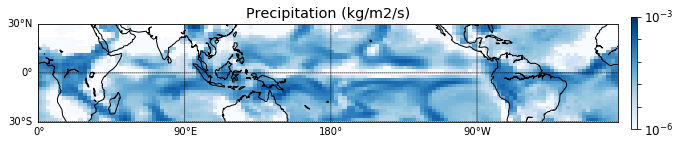

In [35]:
plotMapTropics(lon2D,lat2D,pr[0],title='Precipitation (kg/m2/s)',
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')

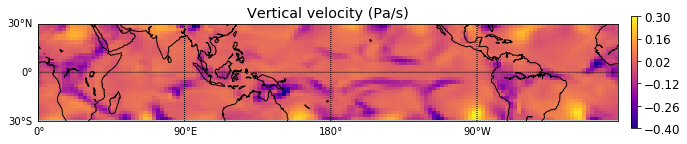

In [47]:
plotMapTropics(lon2D,lat2D,omega_500[0],title='Vertical velocity (Pa/s)',cmap=plt.cm.plasma,
               v_min=-0.4,v_max=0.3,mode='linear',plotfunction='pcolormesh')

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


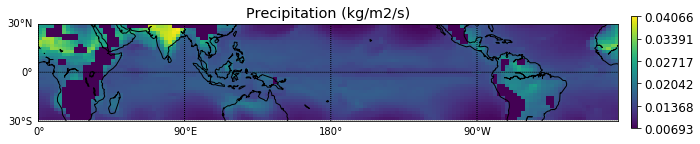

In [45]:
plotMapTropics(lon2D,lat2D,qvstar_925[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.viridis,
               mode='linear',plotfunction='pcolormesh')

In [ ]:
vars2plot = 'pr','omega_500','qvstar_925'
for var in vars2plot:
    
    v = getattr(thismodule,var)[0,...]

    plotMapTropics(lon2D,lat2D,v,v_min=v_lims[var][0],v_max=v_lims[var][1],mode=mode[var],title=var)
    plt.show()

## Example maps of coarsened precipitation

# Figures at a specific scale

# Multiscale figures

In [ ]:
print("Load results as a dataframe")
results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_%s_%s.csv'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pd.read_csv(filepath)

all_varids = results[time_ref][res_ref].keys()